In [1]:
import urllib
import requests
from IPython.core.display import HTML
def css_styling():
    styles = requests.get('https://raw.githubusercontent.com/saadtony/NumericalMethods/master/styles/custom.css')
    return HTML(styles.text)
css_styling()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.animation as animation
%matplotlib inline
%config InlineBackend.figure_format='svg'
plt.rcParams['animation.html'] = 'html5'

In [32]:
# Define the physical domain and other parameters
nx = 32
ny = 32
Lx = 1.
Ly = 1.
ν = 0.05
dx = Lx/(nx-1)
dy = Ly/(ny-1)
Ut = 1.   # Top boundary velocity
dt = min(0.25*dx*dx/ν, 4.*ν/Ut/Ut)

u = np.zeros((ny,nx))
v = np.zeros((ny,nx))
p = np.zeros((ny,nx))
uh = np.zeros((ny,nx))
uy = np.zeros((ny,nx))
print(f'Re: {Ut*Lx/ν:0.2f}')

Re: 20.00


In [33]:
# Define helper functions to compute the divergences in the Navier-Stokes equations
def ddxc(f, dx):
    '''
    Function to compute the first derivative in the x-direction using a centered-difference on f
    '''
    result = np.zeros_like(f)
    result[1:-1,1:-1] = (f[1:-1,2:]-f[1:-1,:-2])/2./dx
    return result

def ddyc(f, dy):
    '''
    Function to compute the first derivative in the y-direction using a centered-difference on f
    '''
    result = np.zeros_like(f)
    result[1:-1,1:-1] = (f[2:,1:-1]-f[:-2,1:-1])/2./dy
    return result

def laplacian(f, dx, dy):
    '''
    Function to compute the laplacian using a centered-difference on f
    '''
    result = np.zeros_like(f)
    result[1:-1,1:-1] = (f[2:,1:-1]-2*f[1:-1,1:-1]+f[:-2,1:-1])/dy/dy + (f[1:-1,2:]-2*f[1:-1,1:-1]+f[1:-1,:-2])/dx/dx
    return result

def div(u, v, dx, dy):
    '''
    Function to compute the divergence of the supplied vectors
    '''
    return ddxc(u, dx) + ddyc(v, dy)

In [34]:
def pressure_poisson(p, dx, dy, b):
    pn = np.empty_like(p)
    it = 0
    err = 1e5
    tol = 1e-3
    maxit = 50
    while it < maxit and err > tol:
        pn = np.copy(p)
        # Explicit solution for the diagonal terms
        p[1:-1,1:-1] = (((pn[1:-1,2:]+pn[1:-1,:-2])*dy**2 + 
                        (pn[2:,1:-1]+pn[:-2,1:-1])*dx**2) /
                        (2*(dx**2 + dy**2)) -
                        dx**2 * dy**2/(2*(dx**2 + dy**2)) * b[1:-1,1:-1])
        
        # Set boundary conditions every iteration. One of the pressure values must be fixed for a unique solution
        ## dp/dx = 0 at x = 0
        p[:,0] = p[:,1]
        ## dp/dx = 0 at x = L
        p[:,-1] = p[:,-2]
        ## dp/dy = 0 at y = 0
        p[0,:] = p[1,:]
        ## p = 0 at the free surface
        p[-1,:] = 0.
        err = np.linalg.norm(p - pn, 2)
        it += 1
        
        
    #print(f'Pressure convergence after {it} steps, error norm = {err:0.3f}')
    return p

# Note on boundary conditions

We know the velocity on the boundaries. The intermediate velocity ($\tilde u$ or $u^*$) is a correction to $u$. On the boundary, we know $u$, and we say that $u$ and $\tilde u$ are equal, so therefore $\nabla p = 0$ on the boundary, or specifically that $\frac{\partial p}{\partial n} = 0$.

In [40]:
t = 0.
tend = 4000 * dt
## MAIN LOOP ##
while t < tend:
    # Set boundary conditions
    ## Left wall
    u[:,0] = 0.
    v[:,0] = 0.
    ## Right wall
    u[:,-1] = 0.
    v[:,-1] = 0.
    ## Top wall
    u[-1,:] = Ut
    v[-1,:] = 0.
    ## Bottom wall
    u[0,:] = 0.
    v[0,:] = 0.
    
    # x-momentum RHS
    ## u rhs: -d(uu)/dx - d(uv)/dy + ν*d2(x)
    urhs = -ddxc(u*u, dx) - ddyc(u*v, dy) + ν*laplacian(u, dx, dy)
    # y-momentum RHS
    ## v rhs: -d(vu)/dx - d(vv)/dy + ν*d2(x) 
    vrhs = -ddxc(v*u, dx) - ddyc(v*v, dy) + ν*laplacian(v, dx, dy)
    
    # Calculate the intermediate velocities
    uh = u + dt*urhs
    vh = v + dt*vrhs
    
    # pressure poisson rhs: div(uh)/dt
    prhs = div(uh,vh,dx,dy)/dt
    p = pressure_poisson(p, dx, dy, prhs)
    
    # Compute true velocities
    ## u_{n+1} = uh - dt*dp/dx
    u = uh - dt*ddxc(p,dx)
    v = vh - dt*ddyc(p,dy)
    
    t += dt

In [41]:
x = np.linspace(0, Lx, nx)
y = np.linspace(0, Ly, ny)
xx, yy = np.meshgrid(x, y)

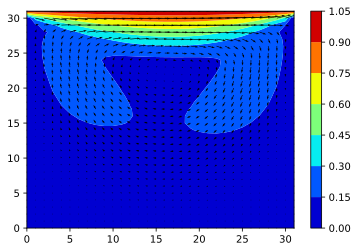

In [42]:
vel = np.sqrt(u**2 + v**2)
plt.contourf(vel, cmap=cm.jet)
plt.colorbar()
plt.quiver(u,v)

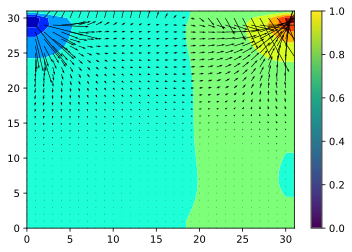

In [43]:
plt.contourf(p,cmap=cm.jet)
plt.quiver(ddx(p,dx),ddy(p,dy))
plt.colorbar()

# Analysis
Notice there's some unusual behavior of the pressure field. What's plotted above is a quiver plot of the pressure gradient, which shows some relatively large gradients in the corners. What's going on there?

## Div-Grad problem
The first assumption made in this finite difference formulation of the Navier-Stokes equations is that the term $u_{ij}^{n+1}$ is divergence-free (for incompressible flows), which we enforce via the poisson pressure equation. If we plot the velocity divergence:

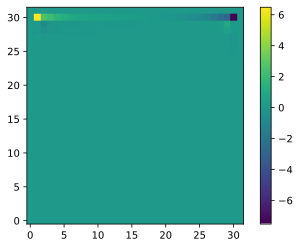

In [47]:
divu = div(u,v,dx,dy)
plt.imshow(divu,origin='lower')
plt.colorbar()

We can see that although the majority of the velocity field is divergence-free, the top part of the domain is not, which coincides with the strange pressure behavior observed above. 

This behavior stems from an assumption made in the generation of the poisson pressure equation, and that assumption is namely that $\nabla^2p = \nabla \cdot \nabla p$. In a continuous formulation, this is obviously true, but in a numerical formulation, it is not.

The Laplacian of the pressure is represented by a second difference. Taking only the x-component of the Laplacian:

$$\nabla^{2} p_x\  =\  \frac{p^{n}_{i,j+1}-2p^{n}_{ij}+p^{n}_{ij-1}}{\Delta x^{2}} $$

Meanwhile, "div-grad" of the pressure is:

$$\nabla_{h} \cdot \nabla_{h} p=\frac{(\nabla_{h} p)_{i+1}-(\nabla_{h} p)_{i-1}}{2\Delta x}$$

where the RHS is the centered differenc (x-direction only) of the gradient of $p$. The centered differences of each of the gradients are:

$$(\nabla_{h} p)_{i+1}\  =\  \frac{p_{i+2}-p_{i}}{2\Delta x} $$

and

$$(\nabla_{h} p)_{i-1}\  =\  \frac{p_{i}-p_{i-2}}{2\Delta x} $$

and therefore:

$$\frac{(\nabla_{h} p)_{i+1}-(\nabla_{h} p)_{i-1}}{2\Delta x} = \frac{p_{i+2}-2p_{i}+p_{i-2}}{4\Delta x^{2}} $$

By inspection, it's clear that the Laplacian and "div-grad" are not equivalent operators in the numerical scheme.

# Getting a divergence-free velocity field

One cannot just use the "wide stencil" for the Laplacian, because this results in odd-even decoupling, or pressure checkerboarding. This causes a numerical scenario where the pressure discretization is only loosely coupled at the even and odd points. The pressure will be oscillatory, and therefore a centered-difference will return a zero gradient, even though there is a large, oscillatory gradient. One of the more widely used solutions is the _staggered grid_.

## Staggered Grid

A staggered grid stores the velocity and pressure values at different points. However, the integration of the momentum equations must occur at the same point. Consider a grid where the pressures are stored at points shifted to the right by a half space. If a centered difference is used to compute the velocity:

$$\frac{\partial u}{\partial x}_{ui} =\frac{u_{i+1}-u_{i-1}}{2\Delta x} $$

If we were to compute the pressure gradient at $u_i$, we must perform a backward difference:

$$ \frac{\partial p}{\partial x}_{u_{i}} =\frac{p_{i}-p_{i-1}}{\Delta x} $$

This forward difference, although of first-order accuracy in $p$ is second-order accurate at $u_i$. Alternatively, you can formulate a scheme centered at $p_i$ where a forward difference in $u$ results. Now, if we look to perform the velocity update using the pressure gradient centered at the point $u_i$:

$$ u^{n+1}_{i}=\tilde{u}_{i} -\Delta t\frac{\partial p}{\partial x}_{u_{i}} $$

### Staggered grid scheme

Now, if we want to check is our velocity is divergence free, we will perform pressure gradients at $u_i$ and velocity gradients at $p_i$, resulting in a numerical scheme that seems to involve first-order finite differences, but actually is second order at the location where the finite differences are centered. Taking the divergence of the equation above (only in the x-direction, aka 1D, for clarity):

$$ \frac{\partial u}{\partial x}^{n+1}_{p_{i}} =\frac{\partial \tilde{u} }{\partial x}_{p_{i}} -\Delta t\frac{\partial }{\partial x} \left( \frac{\partial p}{\partial x}_{u_{i}} \right)_{p_{i}}  $$

The inner derivative performs a second-order difference for the pressure at $u_i$, and then the outer gradient moves the operation to $p_i$, where the rest of the finite differences in the equation are performed. The numerical expansion of the equation above results in:

$$ \frac{\partial u}{\partial x}^{n+1}_{p_{i}} =\frac{\tilde{u}_{i+1} -\tilde{u}_{i} }{\Delta x} -\Delta t\frac{\frac{\partial p}{\partial x}_{u_{i+1}} -\frac{\partial p}{\partial x}_{u_{i}} }{\Delta x} $$

where in the Laplacian for the pressure we see that we write a difference of differences centered at $p_i$, and each individual difference is centered at a velocity node, giving:

$$ \frac{\partial u}{\partial x}^{n+1}_{p_{i}} =\frac{\tilde{u}_{i+1} -\tilde{u}_{i} }{\Delta x} -\Delta t\frac{\frac{p_{i+1}-p_{i}}{\Delta x} -\frac{p_{i}-p_{i-1}}{\Delta x} }{\Delta x} $$

The term all the way on the right is equivalent to the numerical Laplacian of $p$, and now div-grad is equal to the Laplacian. This staggered grid lends itself to the **finite volume method.**